In [1]:
import yfinance as yf
import pandas as pd

In [2]:
df = yf.download("YPF",progress=False)

In [3]:
#Cambio indice de fecha a columna
df.reset_index(inplace=True,drop=False)

#Renombro las columnas
df.rename(columns={'Adj Close':'Adj_Close'}, inplace=True)

#Invierto el dataframe
#df = df.iloc[::-1]

In [4]:
from matplotlib import pyplot as plt

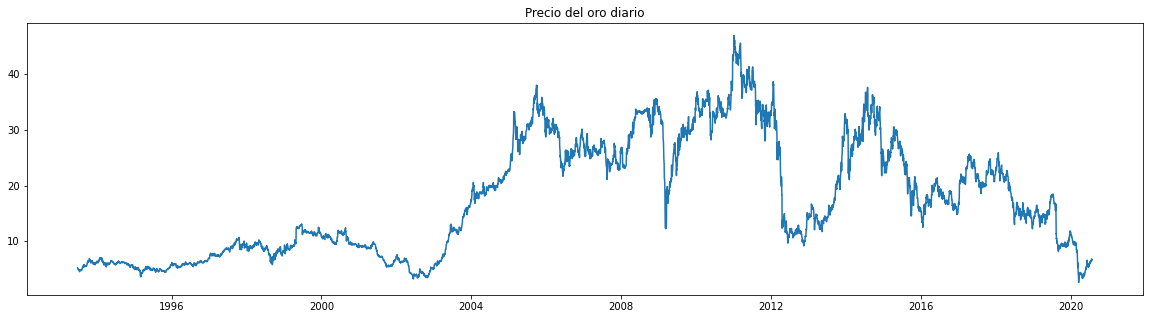

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(df.Date, df.Adj_Close)
plt.title('Precio del oro diario')
plt.show()

## Creo la variable target

In [6]:
df['difference'] = -df.Adj_Close.diff(-1)

In [7]:
df.loc[df.difference > 0, 'target'] = 1
df.loc[df.difference < 0, 'target'] = 0

In [8]:
df.drop(columns='difference', inplace=True)
df.dropna(inplace=True)

In [9]:
df

Date    Open    High     Low   Close  Adj_Close    Volume  target
0    1993-06-29  21.250  22.125  21.125  21.875   5.182673  34346800     0.0
1    1993-06-30  22.000  23.000  21.625  21.750   5.153057   9060600     0.0
2    1993-07-01  21.375  21.625  21.000  21.250   5.034597   4273100     0.0
3    1993-07-02  21.125  21.250  20.750  21.125   5.004982   2504500     0.0
4    1993-07-06  20.875  21.000  20.625  20.750   4.916135   2030400     1.0
...         ...     ...     ...     ...     ...        ...       ...     ...
6813 2020-07-20   6.420   6.420   6.210   6.410   6.410000   1466600     1.0
6814 2020-07-21   6.500   6.650   6.410   6.490   6.490000   1140100     1.0
6815 2020-07-22   6.490   6.740   6.380   6.640   6.640000    995600     1.0
6816 2020-07-23   6.700   7.030   6.570   6.810   6.810000   1636000     0.0
6817 2020-07-24   6.650   6.750   6.490   6.660   6.660000   1498800     0.0

[6487 rows x 8 columns]

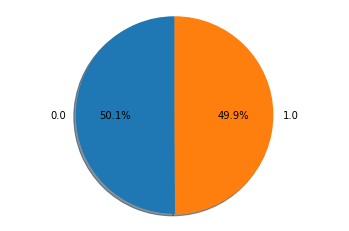

In [10]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df.target.unique()
sizes = df.target.value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Clase backtesting

In [11]:
class BackTesting():

    def __init__(self):
        self.long = False
        self.short = False
        self.balance = 0
        self.last_price = 0
        self.good_trades= 0
        self.bad_trades = 0
        self.percent_good_operations = 0
        self.open_trade_count = 0
        self.history = pd.DataFrame(columns=['Date','Close','buy_long','sell_long','buy_short','sell_short'])
        #print('------------------------------------------------------------')
        
    def open_long(self, price, date):
        self.last_price = price
        self.history.loc[self.history.Date == date, 'buy_long'] = price
        self.long = True
        #print('Entro largo: ', date)

    def close_long(self, price, date):
        profit = price - self.last_price

        if profit > 0:
            self.good_trades += 1
        elif profit < 0:
            self.bad_trades += 1

        self.balance += profit
        self.history.loc[self.history.Date == date, 'sell_long'] = price
        self.long = False
        #print('Cierro largo: ', date)

        
    def open_short(self, price, date):
        self.last_price = price
        self.history.loc[self.history.Date == date, 'sell_short'] = price
        self.short = True
        #print('Entro corto: ', date)
        
    def close_short(self, price, date):
        profit = self.last_price - price

        if profit > 0:
            self.good_trades += 1
        elif profit < 0:
            self.bad_trades += 1

        self.balance += profit
        self.history.loc[self.history.Date == date, 'buy_short'] = price
        self.short = False
        #print('Cierro corto', date)
    
    def run(self, y_preds, df):
        self.history['Date'] = df.Date
        self.history['Close'] = df.Adj_Close

        dates = df.Date.tolist()
        closes_prices = df.Close.tolist()
    
        for p in range(len(y_preds)):
            
            #si esta con una operacion abierta y pasaron mas de 5 intervalos de tiempo la cierro
            if(self.short or self.long):
                self.open_trade_count += 1
                
                if self.open_trade_count > 5:
                    
                    self.open_trade_count = 0
                    
                    if self.long:
                        self.close_long(closes_prices[p], dates[p]);
                      
                    if self.short:
                        self.close_short(closes_prices[p], dates[p])
            
            else:
                
                if(not(self.short)):
                    #si el modelo predice que va a subir, y no tengo operaciones abiertas, entonces compro
                    if y_preds[p] > 0.5 and not(self.long):
                        self.open_long(closes_prices[p], dates[p])

                    #si el modelo predice que va a bajar, y estoy en largo, vendo.
                    if y_preds[p] < 0.5 and self.long:
                        self.close_long(closes_prices[p], dates[p])
                    
                if(not(self.long)):
                    #si el modelo predice que va a bajar y no tengo operaciones abiertas, vendo
                    if y_preds[p] < 0.5 and not(self.short):
                        self.open_short(closes_prices[p], dates[p])

                    #Si el modelo predice que va a subir y estoy en corto, com
                    if y_preds[p] > 0.5 and self.short:
                        self.close_short(closes_prices[p], dates[p])
                    
        self.percent_good_operations = self.good_trades/(self.good_trades+self.bad_trades) if (self.good_trades+self.bad_trades > 0) else 0     
        
        return self.balance, self.good_trades, self.bad_trades, self.percent_good_operations, self.history

## Funcion get_all_indicators

In [12]:
import talib
def get_all_indicators(dataframe):
    candles_indicators = dataframe.copy()    
    candles_indicators["RSI"] = talib.RSI(candles_indicators["Close"], timeperiod=14)
    candles_indicators["EMA12"] = talib.EMA(candles_indicators["Close"], timeperiod=12)
    candles_indicators["EMA26"] = talib.EMA(candles_indicators["Close"], timeperiod=26) 

    upper_band, middle_band, lower_band = talib.BBANDS(candles_indicators["Close"], timeperiod=20, 
                                                nbdevup=2, nbdevdn=2, matype=0)

    candles_indicators["Upper_BBand"] = upper_band
    candles_indicators["Middle_BBand"] = middle_band
    candles_indicators["Lower_BBand"] = lower_band


    macd, macd_signal, macd_hist = talib.MACD(candles_indicators["Close"], fastperiod=12, slowperiod=26, 
                                        signalperiod=9)

    candles_indicators["MACD"] = macd 
    candles_indicators["MACD_Signal"] = macd_signal 
    candles_indicators["MACD_Hist"] = macd_hist

    #k, d = talib.STOCH(candles_indicators["High"], candles_indicators["Low"], 
    #            candles_indicators["Close"], fastk_period=5, slowk_period=3, 
    #            slowk_matype=0, slowd_period=3, slowd_matype=0)

    #candles_indicators["K"] = k
    #candles_indicators["D"] = d
        
    return candles_indicators

In [13]:
df = get_all_indicators(df)
df.head()

Date    Open    High     Low   Close  Adj_Close    Volume  target  \
0 1993-06-29  21.250  22.125  21.125  21.875   5.182673  34346800     0.0   
1 1993-06-30  22.000  23.000  21.625  21.750   5.153057   9060600     0.0   
2 1993-07-01  21.375  21.625  21.000  21.250   5.034597   4273100     0.0   
3 1993-07-02  21.125  21.250  20.750  21.125   5.004982   2504500     0.0   
4 1993-07-06  20.875  21.000  20.625  20.750   4.916135   2030400     1.0   

   RSI  EMA12  EMA26  Upper_BBand  Middle_BBand  Lower_BBand  MACD  \
0  NaN    NaN    NaN          NaN           NaN          NaN   NaN   
1  NaN    NaN    NaN          NaN           NaN          NaN   NaN   
2  NaN    NaN    NaN          NaN           NaN          NaN   NaN   
3  NaN    NaN    NaN          NaN           NaN          NaN   NaN   
4  NaN    NaN    NaN          NaN           NaN          NaN   NaN   

   MACD_Signal  MACD_Hist  
0          NaN        NaN  
1          NaN        NaN  
2          NaN        NaN  
3          NaN        NaN  
4          NaN        NaN

## Feature engineering

In [14]:
df["Date"] = pd.to_datetime(df["Date"])
df["day"] = df["Date"].dt.day
df["day_of_week"] = df["Date"].dt.weekday
df["week"] = df["Date"].dt.week
df["month"] = df["Date"].dt.month
df["quarter"] = df["Date"].dt.quarter
df["year"] = df["Date"].dt.year
#df.drop(columns=['Date'], inplace=True)
df.head()

Date    Open    High     Low   Close  Adj_Close    Volume  target  \
0 1993-06-29  21.250  22.125  21.125  21.875   5.182673  34346800     0.0   
1 1993-06-30  22.000  23.000  21.625  21.750   5.153057   9060600     0.0   
2 1993-07-01  21.375  21.625  21.000  21.250   5.034597   4273100     0.0   
3 1993-07-02  21.125  21.250  20.750  21.125   5.004982   2504500     0.0   
4 1993-07-06  20.875  21.000  20.625  20.750   4.916135   2030400     1.0   

   RSI  EMA12  ...  Lower_BBand  MACD  MACD_Signal  MACD_Hist  day  \
0  NaN    NaN  ...          NaN   NaN          NaN        NaN   29   
1  NaN    NaN  ...          NaN   NaN          NaN        NaN   30   
2  NaN    NaN  ...          NaN   NaN          NaN        NaN    1   
3  NaN    NaN  ...          NaN   NaN          NaN        NaN    2   
4  NaN    NaN  ...          NaN   NaN          NaN        NaN    6   

   day_of_week  week  month  quarter  year  
0            1    26      6        2  1993  
1            2    26      6        2  1993  
2            3    26      7        3  1993  
3            4    26      7        3  1993  
4            1    27      7        3  1993  

[5 rows x 23 columns]

In [15]:
df.dropna(inplace=True)

In [16]:
df['discrete_rsi'] = 0
df.loc[df.RSI >= 70, 'discrete_rsi'] = 1
df.loc[df.RSI <= 30, 'discrete_rsi'] = -1

In [17]:
df['discrete_ema12_ema26'] = -1
df.loc[df.EMA12 > df.EMA26, 'discrete_ema12_ema26'] = 1

In [18]:
df['discrete_ema_12'] = 0
df.loc[df.Close > df.EMA12, 'discrete_ema_12'] = 1
df.loc[df.Close < df.EMA12, 'discrete_ema_12'] = -1
df.dropna(inplace=True)

In [19]:
df['discrete_bollinger_bands'] = 0
df.loc[df.Close > df.Upper_BBand, 'discrete_bollinger_bands'] = 1
df.loc[df.Close < df.Lower_BBand, 'discrete_bollinger_bands'] = -1

In [20]:
df['discrete_macd_signal'] = -1
df.loc[df.MACD_Signal > 0, 'discrete_macd_signal'] = 1

df['discrete_macd_hist'] = -1
df.loc[df.MACD_Hist > 0, 'discrete_macd_signal'] = 1

df['discrete_macd_hist_signal'] = -1
df.loc[df.MACD_Hist > df.MACD_Signal, 'discrete_macd_signal'] = 1

In [21]:
#df.loc[df.K > 80, 'discrete_stochastic'] = 1
#df.loc[df.K < 20, 'discrete_stochastic'] = -1
#df['discrete_kd'] = 0
#df.loc[df.K > df.D, 'discrete_kd'] = 1
#df.loc[df.K < df.D, 'discrete_kd'] = -1
#df['discrete_kd_shifted'] = df.discrete_kd.shift(-1)

In [22]:
#shiftear todo lo de arriba

## Shifteo de todas las variables del feature engineering

In [23]:
df['adj_close_shifted_1'] = df.Adj_Close.shift(1)
df['adj_close_shifted_2'] = df.Adj_Close.shift(2)
df['adj_close_shifted_3'] = df.Adj_Close.shift(3)

In [24]:
df['discrete_rsi_shifted_1'] = df.discrete_rsi.shift(1)
df['discrete_rsi_shifted_2'] = df.discrete_rsi.shift(2)
df['discrete_rsi_shifted_3'] = df.discrete_rsi.shift(3)

In [25]:
df['discrete_ema12_ema26_Shifted_1'] = df.discrete_ema12_ema26.shift(1)
df['discrete_ema12_ema26_Shifted_2'] = df.discrete_ema12_ema26.shift(2)
df['discrete_ema12_ema26_Shifted_3'] = df.discrete_ema12_ema26.shift(3)

In [26]:
df['discrete_ema_12_shifted_1'] = df.discrete_ema_12.shift(1)
df['discrete_ema_12_shifted_2'] = df.discrete_ema_12.shift(2)
df['discrete_ema_12_shifted_3'] = df.discrete_ema_12.shift(3)

In [27]:
df['discrete_macd_signal_shifted_1'] = df.discrete_macd_signal.shift(1)
df['discrete_macd_signal_shifted_2'] = df.discrete_macd_signal.shift(2)
df['discrete_macd_signal_shifted_3'] = df.discrete_macd_signal.shift(3)

In [28]:
df['discrete_macd_hist_shifted_1'] = df.discrete_macd_hist.shift(1)
df['discrete_macd_hist_shifted_2'] = df.discrete_macd_hist.shift(2)
df['discrete_macd_hist_shifted_3'] = df.discrete_macd_hist.shift(3)

In [29]:
df['discrete_macd_hist_signal_shifted_1'] = df.discrete_macd_hist_signal.shift(1)
df['discrete_macd_hist_signal_shifted_2'] = df.discrete_macd_hist_signal.shift(2)
df['discrete_macd_hist_signal_shifted_3'] = df.discrete_macd_hist_signal.shift(3)

In [30]:
df

Date    Open    High     Low   Close  Adj_Close   Volume  target  \
36   1993-08-19  22.750  22.750  21.875  22.000   5.212287  1280300     1.0   
38   1993-08-23  22.625  22.625  22.375  22.625   5.360366   443600     1.0   
39   1993-08-24  22.625  23.000  22.125  23.000   5.449212   650900     1.0   
40   1993-08-25  23.250  23.750  23.250  23.250   5.508441  2541300     1.0   
41   1993-08-26  23.375  24.000  23.250  24.000   5.686132  1243500     0.0   
...         ...     ...     ...     ...     ...        ...      ...     ...   
6813 2020-07-20   6.420   6.420   6.210   6.410   6.410000  1466600     1.0   
6814 2020-07-21   6.500   6.650   6.410   6.490   6.490000  1140100     1.0   
6815 2020-07-22   6.490   6.740   6.380   6.640   6.640000   995600     1.0   
6816 2020-07-23   6.700   7.030   6.570   6.810   6.810000  1636000     0.0   
6817 2020-07-24   6.650   6.750   6.490   6.660   6.660000  1498800     0.0   

            RSI      EMA12  ...  discrete_ema_12_shifted_3  \
36    58.108730  21.439732  ...                        NaN   
38    63.129141  21.622081  ...                        NaN   
39    65.779123  21.834069  ...                        NaN   
40    67.458288  22.051904  ...                        1.0   
41    71.911176  22.351611  ...                        1.0   
...         ...        ...  ...                        ...   
6813  61.625725   6.228941  ...                        1.0   
6814  63.075521   6.269104  ...                        1.0   
6815  65.692738   6.326165  ...                        1.0   
6816  68.424354   6.400601  ...                        1.0   
6817  63.611565   6.440509  ...                        1.0   

      discrete_macd_signal_shifted_1  discrete_macd_signal_shifted_2  \
36                               NaN                             NaN   
38                               1.0                             NaN   
39                               1.0                             1.0   
40                               1.0                             1.0   
41                               1.0                             1.0   
...                              ...                             ...   
6813                             1.0                             1.0   
6814                             1.0                             1.0   
6815                             1.0                             1.0   
6816                             1.0                             1.0   
6817                             1.0                             1.0   

      discrete_macd_signal_shifted_3  discrete_macd_hist_shifted_1  \
36                               NaN                           NaN   
38                               NaN                          -1.0   
39                               NaN                          -1.0   
40                               1.0                          -1.0   
41                               1.0                          -1.0   
...                              ...                           ...   
6813                             1.0                          -1.0   
6814                             1.0                          -1.0   
6815                             1.0                          -1.0   
6816                             1.0                          -1.0   
6817                             1.0                          -1.0   

      discrete_macd_hist_shifted_2  discrete_macd_hist_shifted_3  \
36                             NaN                           NaN   
38                             NaN                           NaN   
39                            -1.0                           NaN   
40                            -1.0                          -1.0   
41                            -1.0                          -1.0   
...                            ...                           ...   
6813                          -1.0                          -1.0   
6814                          -1.0                          -1.0   

In [31]:
df.dropna(inplace=True)

In [32]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'target',
       'RSI', 'EMA12', 'EMA26', 'Upper_BBand', 'Middle_BBand', 'Lower_BBand',
       'MACD', 'MACD_Signal', 'MACD_Hist', 'day', 'day_of_week', 'week',
       'month', 'quarter', 'year', 'discrete_rsi', 'discrete_ema12_ema26',
       'discrete_ema_12', 'discrete_bollinger_bands', 'discrete_macd_signal',
       'discrete_macd_hist', 'discrete_macd_hist_signal',
       'adj_close_shifted_1', 'adj_close_shifted_2', 'adj_close_shifted_3',
       'discrete_rsi_shifted_1', 'discrete_rsi_shifted_2',
       'discrete_rsi_shifted_3', 'discrete_ema12_ema26_Shifted_1',
       'discrete_ema12_ema26_Shifted_2', 'discrete_ema12_ema26_Shifted_3',
       'discrete_ema_12_shifted_1', 'discrete_ema_12_shifted_2',
       'discrete_ema_12_shifted_3', 'discrete_macd_signal_shifted_1',
       'discrete_macd_signal_shifted_2', 'discrete_macd_signal_shifted_3',
       'discrete_macd_hist_shifted_1', 'discrete_macd_hist_shifted_2',


In [33]:
cols = ['RSI', 'EMA12', 'EMA26', 'Upper_BBand', 'Middle_BBand', 'Lower_BBand', 'MACD', 'MACD_Signal', 
        'MACD_Hist']
df.drop(columns=cols, inplace=True)

In [34]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'target',
       'day', 'day_of_week', 'week', 'month', 'quarter', 'year',
       'discrete_rsi', 'discrete_ema12_ema26', 'discrete_ema_12',
       'discrete_bollinger_bands', 'discrete_macd_signal',
       'discrete_macd_hist', 'discrete_macd_hist_signal',
       'adj_close_shifted_1', 'adj_close_shifted_2', 'adj_close_shifted_3',
       'discrete_rsi_shifted_1', 'discrete_rsi_shifted_2',
       'discrete_rsi_shifted_3', 'discrete_ema12_ema26_Shifted_1',
       'discrete_ema12_ema26_Shifted_2', 'discrete_ema12_ema26_Shifted_3',
       'discrete_ema_12_shifted_1', 'discrete_ema_12_shifted_2',
       'discrete_ema_12_shifted_3', 'discrete_macd_signal_shifted_1',
       'discrete_macd_signal_shifted_2', 'discrete_macd_signal_shifted_3',
       'discrete_macd_hist_shifted_1', 'discrete_macd_hist_shifted_2',
       'discrete_macd_hist_shifted_3', 'discrete_macd_hist_signal_shifted_1',
       'discrete_macd_hist_signal_sh

In [35]:
df.iloc[:, 8:]

day  day_of_week  week  month  quarter  year  discrete_rsi  \
40     25            2    34      8        3  1993             0   
41     26            3    34      8        3  1993             1   
42     27            4    34      8        3  1993             0   
44     31            1    35      8        3  1993             0   
45      1            2    35      9        3  1993             1   
...   ...          ...   ...    ...      ...   ...           ...   
6813   20            0    30      7        3  2020             0   
6814   21            1    30      7        3  2020             0   
6815   22            2    30      7        3  2020             0   
6816   23            3    30      7        3  2020             0   
6817   24            4    30      7        3  2020             0   

      discrete_ema12_ema26  discrete_ema_12  discrete_bollinger_bands  ...  \
40                       1                1                         0  ...   
41                       1                1                         1  ...   
42                       1                1                         0  ...   
44                       1                1                         0  ...   
45                       1                1                         0  ...   
...                    ...              ...                       ...  ...   
6813                     1                1                         0  ...   
6814                     1                1                         0  ...   
6815                     1                1                         0  ...   
6816                     1                1                         0  ...   
6817                     1                1                         0  ...   

      discrete_ema_12_shifted_3  discrete_macd_signal_shifted_1  \
40                          1.0                             1.0   
41                          1.0                             1.0   
42                          1.0                             1.0   
44                          1.0                             1.0   
45                          1.0                             1.0   
...                         ...                             ...   
6813                        1.0                             1.0   
6814                        1.0                             1.0   
6815                        1.0                             1.0   
6816                        1.0                             1.0   
6817                        1.0                             1.0   

      discrete_macd_signal_shifted_2  discrete_macd_signal_shifted_3  \
40                               1.0                             1.0   
41                               1.0                             1.0   
42                               1.0                             1.0   
44                               1.0                             1.0   
45                               1.0                             1.0   
...                              ...                             ...   
6813                             1.0                             1.0   
6814                             1.0                             1.0   
6815                             1.0                             1.0   
6816                             1.0                             1.0   
6817                             1.0                             1.0   

      discrete_macd_hist_shifted_1  discrete_macd_hist_shifted_2  \
40                            -1.0                          -1.0   
41                            -1.0                          -1.0   
42                            -1.0                          -1.0   
44                            -1.0                          -1.0   
45                            -1.0                          -1.0   
...                            ...                           ...   
6813                          -1.0                          -1.0   
6814                          -1.0    

# Entrenamiento por ventana deslizante

In [57]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import numpy as np
from IPython.display import clear_output

def sliding_window_training(drop_cols_to_train, target, do_backtesting=False, model=None, window_size=16, 
                            steps=1, data=None, test_size=1,show_progress=True):
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    final_metrics = defaultdict(list)
    i = window_size
    
    number_of_steps = round(len(data)) - window_size
    step = 0

    while i < len(data):
        #si i se pasa del largo del df al sumar los pasos de la ventana, lo reduzco al largo del dataframe
        #i += steps if (i + steps < len(data) and (i+test_size < len(data))) else (len(data)) 
        step += 1*steps
        
        i += steps
        train = data[i-window_size:i]
        test = data[i:i+test_size]
        
        if(len(train) > 0 and len(test) > 0):        

            #print(train.iloc[:, :1])
            #print(test.iloc[:, :1])

            x_train = train.drop(columns=drop_cols_to_train)
            x_train = scaler.fit_transform(x_train)
            y_train = train[target]

            x_test = test.drop(columns=drop_cols_to_train)
            x_test = scaler.fit_transform(x_test)
            y_test = test[target]

            history = model.fit(
                x_train,
                y_train,
                batch_size=32,
                epochs=8,
                validation_data=(x_test, y_test),
                verbose=0
            )
            
            #predicciones
            train_predictions = np.around(model.predict(x_train))
            test_predictions = np.around(model.predict(x_test))
            
            #metricas
            final_metrics['train_accuracy'].append(accuracy_score(y_train, train_predictions))
            final_metrics['test_accuracy'].append(accuracy_score(y_test, test_predictions))
            
            #feedback del proceso
            if show_progress:
                clear_output(wait=True)
                print(round((step/number_of_steps)*100), '%')
            
            #Backtesting
            if(do_backtesting):
                backtesting = BackTesting()
                balance, good_trades, bad_trades, percent_good_trades, _ = backtesting.run(test_predictions, test)
                
                final_metrics['balance'].append(balance)
                final_metrics['good_trades'].append(good_trades)
                final_metrics['bad_trades'].append(bad_trades)
                final_metrics['percent_good_trades'].append(percent_good_trades)
                
    df_metrics = pd.DataFrame(final_metrics)
    return df_metrics


## Creacion del modelo

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [38]:
#Red neuronal pequeña
neural_network = Sequential()
neural_network.add(Dense(32,input_dim = df.drop(columns=['Date','target']).shape[1],activation="relu"))
neural_network.add(Dropout(0.2))
neural_network.add(Dense(16,activation="relu"))
neural_network.add(Dropout(0.2))
neural_network.add(Dense(1,activation = "sigmoid")) 
neural_network.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])

print(neural_network.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1312      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,857
Trainable params: 1,857
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
from sklearn.model_selection import train_test_split
df_prueba, _ = train_test_split(df, train_size=0.1, shuffle=False, random_state=42)

In [40]:
len(df_prueba)

645

In [41]:
metrics = sliding_window_training(['target','Date'], 'target', do_backtesting=True, model=neural_network, 
                            window_size=128, steps=1, data=df_prueba, test_size=8,show_progress=True)

100 %


In [42]:
metrics.sample(20)

train_accuracy  test_accuracy   balance  good_trades  bad_trades  \
35         0.937500          0.500  0.390625            1           0   
302        0.734375          0.625  1.000000            1           0   
59         0.976562          0.375  0.875000            1           0   
47         0.953125          0.625  0.625000            1           0   
451        0.757812          0.375  1.500000            1           0   
432        0.773438          0.625  1.312500            1           0   
291        0.773438          0.500  0.875000            1           0   
86         0.945312          0.500  1.000000            1           0   
298        0.781250          0.000 -1.000000            0           1   
37         0.945312          0.625  0.250000            1           0   
100        0.953125          0.375 -0.375000            0           1   
401        0.773438          0.375 -0.265625            0           1   
247        0.804688          0.375 -0.875000            0           1   
300        0.742188          0.625  0.875000            1           0   
221        0.859375          0.875  1.750000            1           0   
353        0.859375          0.750  0.625000            1           0   
436        0.757812          0.625  0.250000            1           0   
72         0.937500          0.750 -0.750000            0           1   
259        0.804688          0.375 -0.125000            0           1   
305        0.710938          0.500  0.500000            1           0   

     percent_good_trades  
35                   1.0  
302                  1.0  
59                   1.0  
47                   1.0  
451                  1.0  
432                  1.0  
291                  1.0  
86                   1.0  
298                  0.0  
37                   1.0  
100                  0.0  
401                  0.0  
247                  0.0  
300                  1.0  
221                  1.0  
353                  1.0  
436                  1.0  
72                   0.0  
259                  0.0  
305                  1.0

In [45]:
metrics.describe()

train_accuracy  test_accuracy     balance  good_trades  bad_trades  \
count      516.000000     516.000000  516.000000   516.000000  516.000000   
mean         0.830669       0.618083    0.516655     0.732558    0.207364   
std          0.087742       0.171904    0.855129     0.443054    0.405812   
min          0.546875       0.000000   -3.125000     0.000000    0.000000   
25%          0.757812       0.500000    0.000000     0.000000    0.000000   
50%          0.808594       0.625000    0.500000     1.000000    0.000000   
75%          0.921875       0.750000    1.000000     1.000000    0.000000   
max          0.976562       1.000000    4.625000     1.000000    1.000000   

       percent_good_trades  
count           516.000000  
mean              0.732558  
std               0.443054  
min               0.000000  
25%               0.000000  
50%               1.000000  
75%               1.000000  
max               1.000000

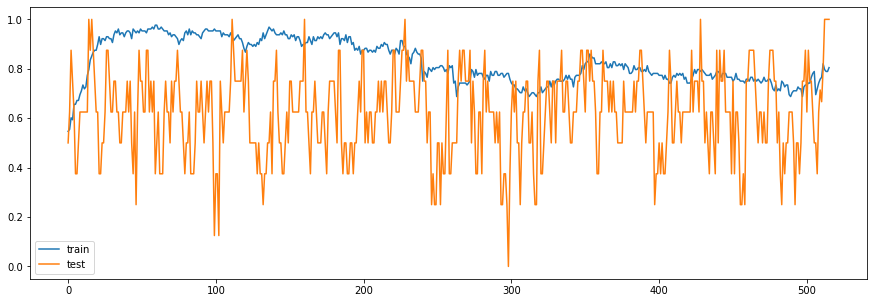

In [47]:
plt.figure(figsize=(15, 5))
plt.plot(range(0, len(metrics)), metrics.train_accuracy, label='train')
plt.plot(range(0, len(metrics)), metrics.test_accuracy, label='test')

plt.xlabel='epoch'
plt.ylabel='accuracy'
plt.title='Accuracy'

plt.legend()
plt.show()

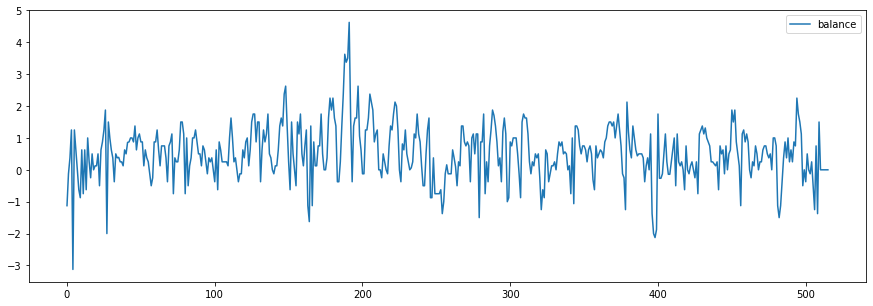

In [49]:
plt.figure(figsize=(15, 5))
plt.plot(range(0, len(metrics)), metrics.balance, label='balance')

plt.xlabel='epoch'
plt.ylabel='accuracy'
plt.title='Accuracy'

plt.legend()
plt.show()

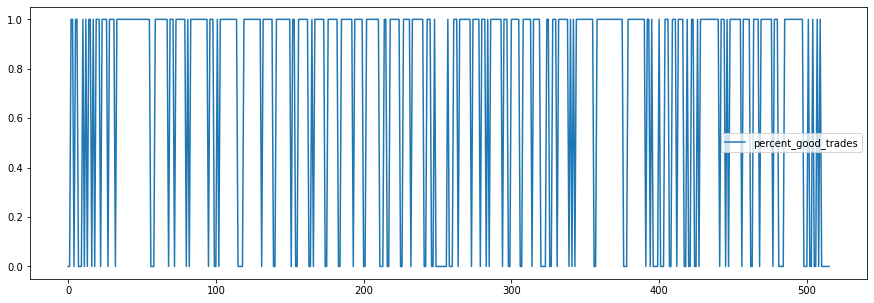

In [51]:
plt.figure(figsize=(15, 5))
plt.plot(range(0, len(metrics)), metrics.good_trades, label='percent_good_trades')

plt.xlabel='epoch'
plt.ylabel='accuracy'
plt.title='Accuracy'

plt.legend()
plt.show()

In [53]:
metrics.balance.sum()

266.59375

In [54]:
balance = metrics.balance.cumsum()

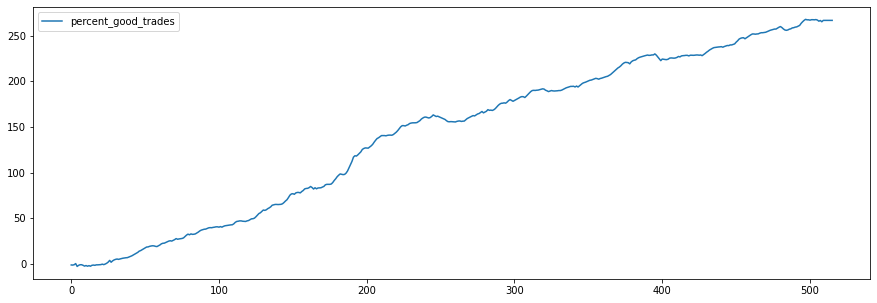

In [56]:
plt.figure(figsize=(15, 5))
plt.plot(range(0, len(metrics)), balance, label='percent_good_trades')

plt.xlabel='epoch'
plt.ylabel='accuracy'
plt.title='Accuracy'

plt.legend()
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(metrics.train_accuracy)
plt.plot(metrics.test_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()